In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/Colab Notebooks/STAT5242_Final_Project/

/content/drive/MyDrive/Colab Notebooks/STAT5242_Final_Project


In [3]:
%cd drive/MyDrive/STAT5242Project/STAT5242_Final_Project/

[Errno 2] No such file or directory: 'drive/MyDrive/STAT5242Project/STAT5242_Final_Project/'
/content/drive/MyDrive/Colab Notebooks/STAT5242_Final_Project


In [4]:
from tensorflow.keras.models import Model
from matplotlib import pyplot as plt
from PIL import Image

import matplotlib.gridspec as gridspec
import tensorflow as tf
import numpy as np

tf.executing_eagerly()

True

In [5]:
def load_image(img_path):
    img = Image.open(img_path)
    
    # limit the size of image to be 512 pixels
    max_dim = 512
    scale = max_dim/max(img.size)
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    img = np.array(img).astype('uint8')
    
    return img


def load_and_process_image(img_path):
    img = load_image(img_path)
    
    # add batch dim for training purpose 
    img = np.expand_dims(img, axis=0)
    
    img = tf.keras.applications.vgg19.preprocess_input(img)
    
    return img

# ???
def deprocess_image(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
  
    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x


def display_result(content_path, style_path, best_img=None):
    content_img = load_image(content_path)
    style_img = load_image(style_path)
    
    fig = plt.figure(figsize=(13,13))
    gridspec.GridSpec(2,2)

    plt.subplot2grid((3,2), (0,0))
    plt.imshow(content_img)
    plt.title('Content Image')
    plt.axis('off')
    
    plt.subplot2grid((3,2), (0,1))
    plt.imshow(style_img)
    plt.title('Style Image')
    plt.axis('off')
    
    if best_img is not None:
        plt.subplot2grid((3,2), (1,0), colspan=2, rowspan=2)
        plt.imshow(best_img)
        plt.title('Style Transfer Output')
        plt.axis('off')

    fig.tight_layout()


In [6]:
def build_model():
    
    # VGG19 based 
    vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg19.trainable = False
    
    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

    content_outputs = [vgg19.get_layer(name).output for name in content_layers]
    style_outputs = [vgg19.get_layer(name).output for name in style_layers]

    model_outputs = content_outputs + style_outputs

    model = Model(inputs=vgg19.input, outputs=model_outputs)
    
    return model
    

def feature_extract(model, img, mode, num_content_layers=1):
    outputs = model(img)

    if mode == 'content':
      feature = [out for out in outputs[:num_content_layers]]
    elif mode == 'style':
      feature = [out for out in outputs[num_content_layers:]]
    
    return feature


In [7]:
def get_content_loss(base_content, target_content):
    return tf.reduce_mean(tf.square(base_content - target_content))


def gram_matrix(input_tensor):
    num_filters = input_tensor.shape[-1]
    
    i = tf.reshape(input_tensor, [-1, num_filters])
    n = i.shape[0]
    gram = tf.matmul(i, i, transpose_a=True)
    
    return gram/n


def get_style_loss(base_style, target_style_gram):
    _, h, w, c = base_style.shape
    
    base_style_gram = gram_matrix(base_style)
    
    return tf.reduce_mean(tf.square(base_style_gram - target_style_gram)) #/ (4 * c**2 * (h*w)**2)


def compute_loss(model, base_img, target_content, target_style_gram, content_weight, style_weight):
    
    content_loss = 0
    style_loss = 0
    
    base_content = feature_extract(model, base_img, mode='content')
    base_style = feature_extract(model, base_img, mode='style')
    
    layer_weight_content = 1/len(target_content)
    for bc, tc in zip(base_content, target_content):
        content_loss += layer_weight_content * get_content_loss(bc, tc)
        
    layer_weight_style = 1/len(target_style_gram)
    for bs, tsg in zip(base_style, target_style_gram):
        style_loss += layer_weight_style * get_style_loss(bs, tsg)
        
    content_loss *= content_weight
    style_loss *= style_weight
    
    total_loss = content_loss + style_loss
    
    return total_loss, content_loss, style_loss
        

In [8]:
def compute_grad(config):
    with tf.GradientTape() as tape:
        total_loss = compute_loss(**config)[0]
    return tape.gradient(total_loss, config['base_img']), total_loss


In [9]:
model = build_model()
def style_transfer(content_path, style_path, content_weight, style_weight, num_iterations=500):

    content_img = load_and_process_image(content_path)
    style_img = load_and_process_image(style_path)
    base_img = tf.Variable(content_img.copy())
    
    target_content = feature_extract(model, content_img, mode='content')
    
    target_style = feature_extract(model, style_img, mode='style')
    target_style_gram = [gram_matrix(ts) for ts in target_style]
    
    config = {'model': model,
              'base_img': base_img,
              'target_content': target_content,
              'target_style_gram': target_style_gram,
              'content_weight': content_weight,
              'style_weight': style_weight}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means 
    
    best_loss, best_image = float('inf'), None
    
    optim = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=0.1)
    
    for i in range(num_iterations):
        grad, total_loss = compute_grad(config)
        optim.apply_gradients([(grad, base_img)])
        # ???
        clipped_img = tf.clip_by_value(base_img, min_vals, max_vals)
        base_img.assign(clipped_img)
        
        if total_loss < best_loss:
            best_loss = total_loss
            best_img = deprocess_image(base_img.numpy())
        
    return best_loss, best_img


80142336/80134624 [==============================] - 1s 0us/step


In [10]:
content_path = 'Image/columbia2.jpg'
style_path = 'Image/impression_sunrise.jpg'

In [11]:
content_path1 = 'Image/content1.jpg'
content_path2 = 'Image/content2.jpg'
style_path1 = 'Image/style1.jpg'
style_path2 = 'Image/style2.jpg'

In [12]:
content_weight = 1e3
style_weight = 1e-2

best_loss11, best_img11 = style_transfer(content_path1, style_path1, content_weight, style_weight, num_iterations=1000)
#best_loss12, best_img12 = style_transfer(content_path1, style_path2, content_weight, style_weight, num_iterations=1000)
#best_loss21, best_img21 = style_transfer(content_path2, style_path1, content_weight, style_weight, num_iterations=1000)
#best_loss22, best_img22 = style_transfer(content_path2, style_path2, content_weight, style_weight, num_iterations=1000)

In [13]:
display_result(content_path1, style_path1, best_img11)

Output hidden; open in https://colab.research.google.com to view.

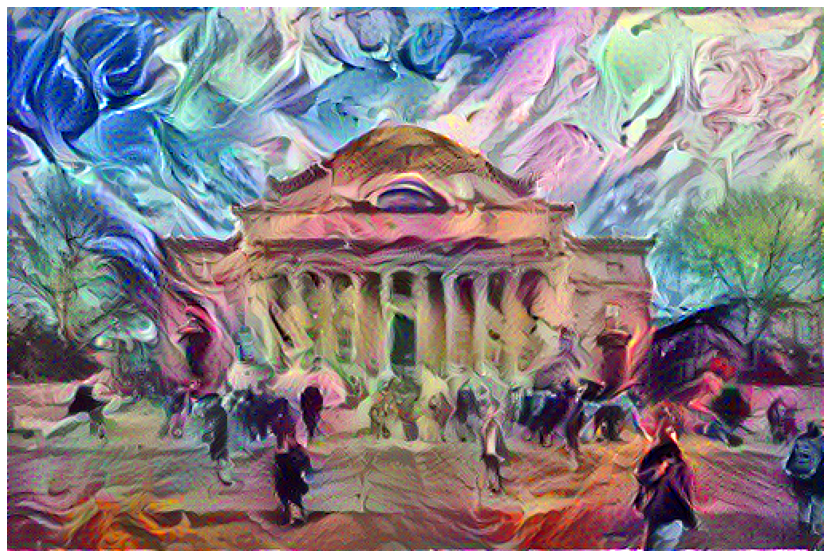

In [14]:
plt.figure(figsize=(15,10))
plt.imshow(best_img11)
plt.axis('off')
plt.savefig('complete.jpg')

In [ ]:
display_result(content_path1, style_path2, best_img12)

Output hidden; open in https://colab.research.google.com to view.

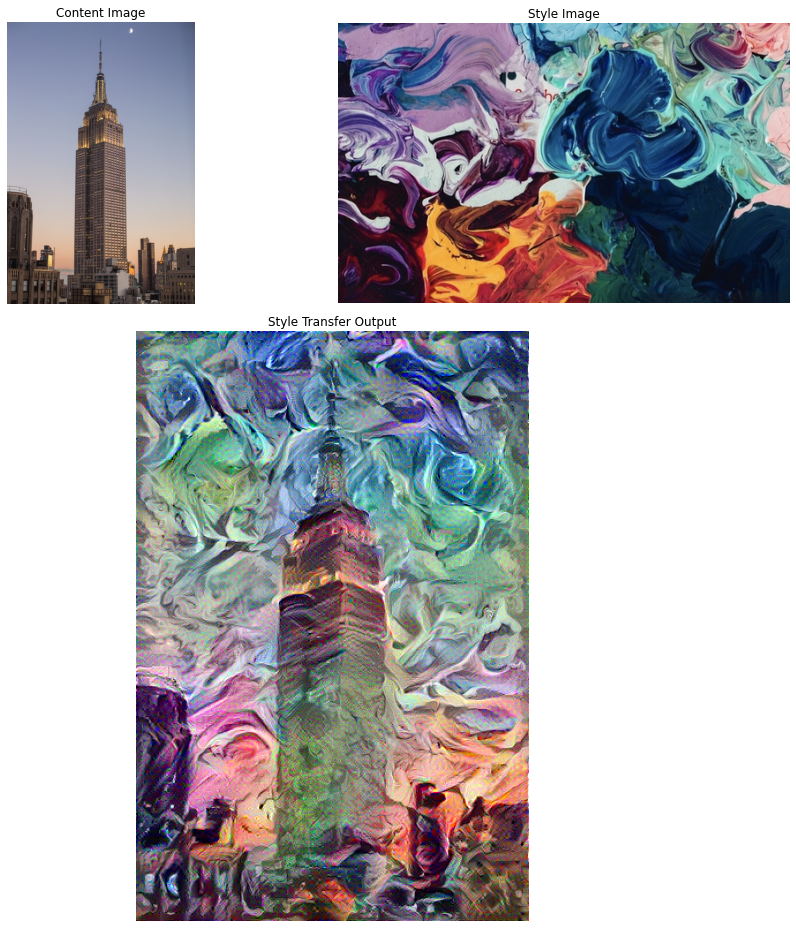

In [ ]:
display_result(content_path2, style_path1, best_img21)

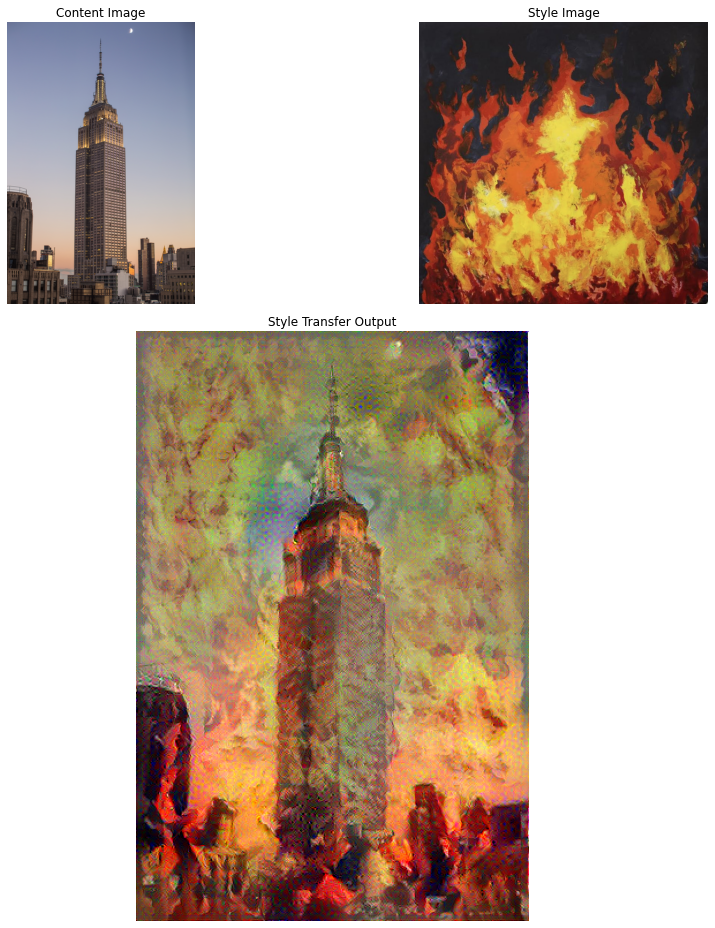

In [ ]:
display_result(content_path2, style_path2, best_img22)

Hyperparameters tuning

Number of iterations

In [ ]:
content_weight = 1e3
style_weight = 1e-2

best_loss11, best_img11 = style_transfer(content_path1, style_path1, content_weight, style_weight, num_iterations=100)
display_result(content_path1, style_path1, best_img11)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
content_weight = 1e3
style_weight = 1e-2

best_loss11, best_img11 = style_transfer(content_path1, style_path1, content_weight, style_weight, num_iterations=500)
display_result(content_path1, style_path1, best_img11)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
content_weight = 1e3
style_weight = 1e-2

best_loss11, best_img11 = style_transfer(content_path1, style_path1, content_weight, style_weight, num_iterations=2000)
display_result(content_path1, style_path1, best_img11)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
content_weight = 1e3
style_weight = 1e-2

best_loss11, best_img11 = style_transfer(content_path1, style_path1, content_weight, style_weight, num_iterations=4000)
display_result(content_path1, style_path1, best_img11)

Output hidden; open in https://colab.research.google.com to view.

Different weights

In [ ]:
content_weight = 1e5
style_weight = 1e-3 #e8

best_loss11, best_img11 = style_transfer(content_path1, style_path1, content_weight, style_weight, num_iterations=1000)
display_result(content_path1, style_path1, best_img11)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
content_weight = 1e1
style_weight = 1e5 #e-6

best_loss11, best_img11 = style_transfer(content_path1, style_path1, content_weight, style_weight, num_iterations=1000)
display_result(content_path1, style_path1, best_img11)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
content_weight = 1e3
style_weight = 1e-1 #e4

best_loss11, best_img11 = style_transfer(content_path1, style_path1, content_weight, style_weight, num_iterations=1000)
display_result(content_path1, style_path1, best_img11)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
content_weight = 1
style_weight = 1e2 #e-2

best_loss11, best_img11 = style_transfer(content_path1, style_path1, content_weight, style_weight, num_iterations=1000)
display_result(content_path1, style_path1, best_img11)

Output hidden; open in https://colab.research.google.com to view.

Different learning rate

In [ ]:
model = build_model()
def style_transfer(content_path, style_path, content_weight, style_weight, num_iterations=500,learning_rate = 5):

    content_img = load_and_process_image(content_path)
    style_img = load_and_process_image(style_path)
    base_img = tf.Variable(content_img.copy())
    
    target_content = feature_extract(model, content_img, mode='content')
    
    target_style = feature_extract(model, style_img, mode='style')
    target_style_gram = [gram_matrix(ts) for ts in target_style]
    
    config = {'model': model,
              'base_img': base_img,
              'target_content': target_content,
              'target_style_gram': target_style_gram,
              'content_weight': content_weight,
              'style_weight': style_weight}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means 
    
    best_loss, best_image = float('inf'), None
    
    optim = tf.keras.optimizers.Adam(learning_rate, beta_1=0.99, epsilon=0.1)
    
    for i in range(num_iterations):
        grad, total_loss = compute_grad(config)
        optim.apply_gradients([(grad, base_img)])
        # ???
        clipped_img = tf.clip_by_value(base_img, min_vals, max_vals)
        base_img.assign(clipped_img)
        
        if total_loss < best_loss:
            best_loss = total_loss
            best_img = deprocess_image(base_img.numpy())
        
    return best_loss, best_img


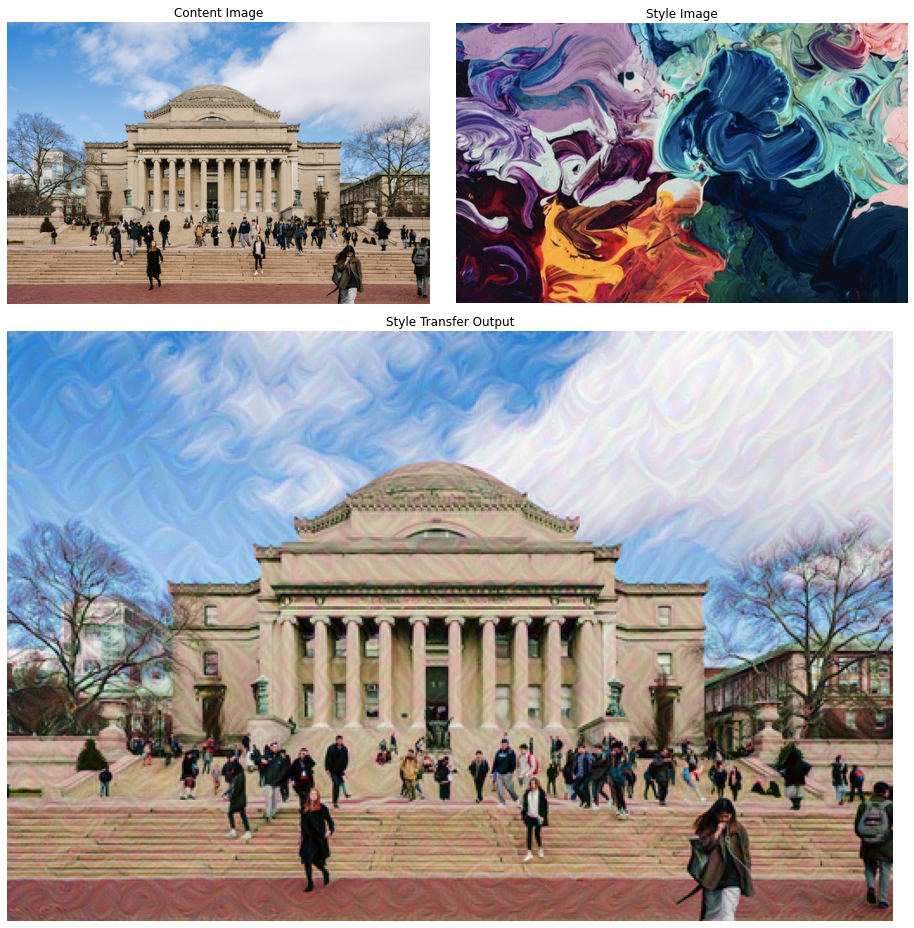

In [ ]:
content_weight = 1e3
style_weight = 1e-2 #lr=0.01

best_loss11, best_img11 = style_transfer(content_path1, style_path1, content_weight, style_weight, num_iterations=1000,learning_rate = 0.01)
display_result(content_path1, style_path1, best_img11)

In [ ]:
content_weight = 1e3
style_weight = 1e-2 #lr=1

best_loss11, best_img11 = style_transfer(content_path1, style_path1, content_weight, style_weight, num_iterations=1000,learning_rate = 1)
display_result(content_path1, style_path1, best_img11)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
content_weight = 1e3
style_weight = 1e-2 #lr=5

best_loss11, best_img11 = style_transfer(content_path1, style_path1, content_weight, style_weight, num_iterations=1000,learning_rate = 5)
display_result(content_path1, style_path1, best_img11)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
content_weight = 1e3
style_weight = 1e-2 #lr=10

best_loss11, best_img11 = style_transfer(content_path1, style_path1, content_weight, style_weight, num_iterations=1000,learning_rate = 10)
display_result(content_path1, style_path1, best_img11)

Output hidden; open in https://colab.research.google.com to view.